<a href="https://colab.research.google.com/github/PanitnanKan/BADS7105-CRM-analysis-and-intelligence/blob/main/Homework%2008/Homework_8_Campaign_Response_Model_improve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold # import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [3]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [4]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


###Data Preparation

In [5]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())
df_transactions['tran_amount'].describe()

2011-05-16 00:00:00
2015-03-16 00:00:00


count    125000.000000
mean         64.991912
std          22.860006
min          10.000000
25%          47.000000
50%          65.000000
75%          83.000000
max         105.000000
Name: tran_amount, dtype: float64

In [6]:
campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions['is_weekend'] = df_transactions['trans_date'].dt.weekday.isin([5,6])
df_transactions.head()

,customer_id,trans_date,tran_amount,recent,is_weekend
0,CS5295,2013-02-11,35,764.0,False
1,CS4768,2015-03-15,39,2.0,True
2,CS2122,2013-02-26,52,749.0,False
3,CS1217,2011-11-16,99,1217.0,False
4,CS1850,2013-11-20,78,482.0,False


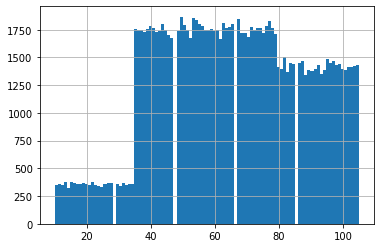

In [7]:
fig= plt.plot(figsize=(15,5))
df_transactions['tran_amount'].hist(bins=100)

In [45]:
weekend_df = df_transactions.groupby(['customer_id','is_weekend'])['tran_amount'].agg(['size','sum']).unstack(fill_value=0)
weekend_df.columns = ['visit_weekday','visit_weekend','spend_weekday','spend_weekend']

recent_df = df_transactions.groupby(['customer_id'])['recent'].agg(['sum','mean'])
recent_df.columns = ['recent_sum','recent_mean']

## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value
                                                    }) 


df_rfm = df_rfm.join(recent_df)
df_rfm = df_rfm.join(weekend_df)
df_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)

#df_rfm = df_rfm.drop(['customer_id'], axis=1)


df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value,recent_sum,recent_mean,visit_weekday,visit_weekend,spend_weekday,spend_weekend
0,CS1112,62.0,15,1012,11319.0,754.600000,10,5,696,316
1,CS1113,36.0,20,1490,13259.0,662.950000,17,3,1296,194
2,CS1114,33.0,19,1432,12826.0,675.052632,13,6,955,477
3,CS1115,12.0,22,1659,17090.0,776.818182,16,6,1183,476
4,CS1116,204.0,13,857,10762.0,827.846154,12,1,797,60


###Calculating response rate

In [46]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


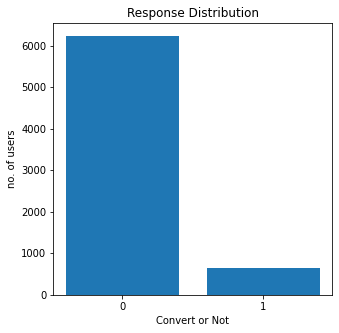

In [50]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

In [51]:
df_modeling = pd.merge(df_response,df_rfm)
df_modeling = df_modeling.set_index('customer_id')
df_modeling.head()

,response,recency,frequency,monetary_value,recent_sum,recent_mean,visit_weekday,visit_weekend,spend_weekday,spend_weekend
customer_id,,,,,,,,,,
CS1112,0,62.0,15,1012,11319.0,754.600000,10,5,696,316
CS1113,0,36.0,20,1490,13259.0,662.950000,17,3,1296,194
CS1114,1,33.0,19,1432,12826.0,675.052632,13,6,955,477
CS1115,1,12.0,22,1659,17090.0,776.818182,16,6,1183,476
CS1116,1,204.0,13,857,10762.0,827.846154,12,1,797,60


###Creating train and test dataset

In [52]:
## spliting dataframe into X and y

X = df_modeling.drop(columns=['response'])
y = df_modeling['response']
X.head()

,recency,frequency,monetary_value,recent_sum,recent_mean,visit_weekday,visit_weekend,spend_weekday,spend_weekend
customer_id,,,,,,,,,
CS1112,62.0,15,1012,11319.0,754.600000,10,5,696,316
CS1113,36.0,20,1490,13259.0,662.950000,17,3,1296,194
CS1114,33.0,19,1432,12826.0,675.052632,13,6,955,477
CS1115,12.0,22,1659,17090.0,776.818182,16,6,1183,476
CS1116,204.0,13,857,10762.0,827.846154,12,1,797,60


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 9)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 9)
Number transactions y_test dataset:  (2066,)


Text(0.5, 1.0, 'Imbalanced Data')

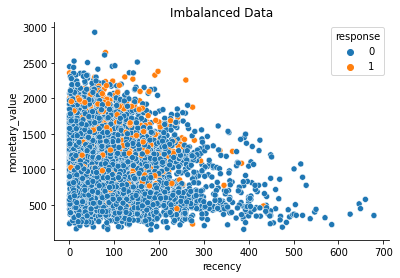

In [55]:
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

###Fix imbalabce

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

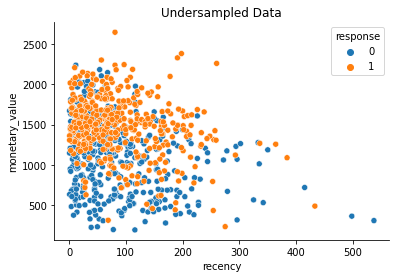

In [56]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency', 'frequency', 'monetary_value','recent_sum','recent_mean','visit_weekday','visit_weekend','spend_weekday','spend_weekend','response']

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

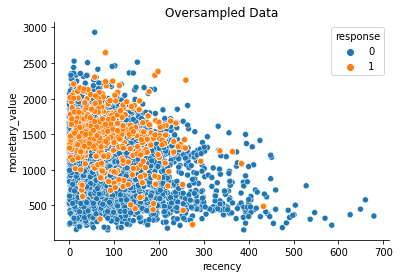

In [57]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value','recent_sum','recent_mean','visit_weekday','visit_weekend','spend_weekday','spend_weekend','response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

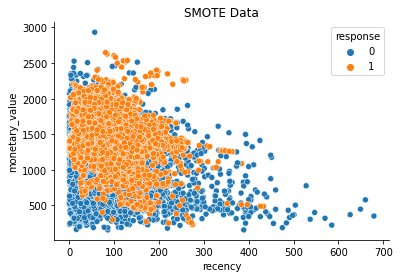

In [58]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'frequency', 'monetary_value','recent_sum','recent_mean','visit_weekday','visit_weekend','spend_weekday','spend_weekend','response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

###Choose Train with XGBoost model - SMOTE

In [59]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

XGBoost model - SMOTE
[0]	validation_0-auc:0.726415
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.74967
[2]	validation_0-auc:0.745418
[3]	validation_0-auc:0.750508
[4]	validation_0-auc:0.758967
[5]	validation_0-auc:0.759199
[6]	validation_0-auc:0.759261
[7]	validation_0-auc:0.76244
[8]	validation_0-auc:0.759291
[9]	validation_0-auc:0.756659
[10]	validation_0-auc:0.761772
[11]	validation_0-auc:0.761213
[12]	validation_0-auc:0.761652
Stopping. Best iteration:
[7]	validation_0-auc:0.76244

training set
              precision    recall  f1-score   support

           0       0.80      0.70      0.75      4389
           1       0.73      0.83      0.78      4389

    accuracy                           0.76      8778
   macro avg       0.77      0.76      0.76      8778
weighted avg       0.77      0.76      0.76      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1848
          

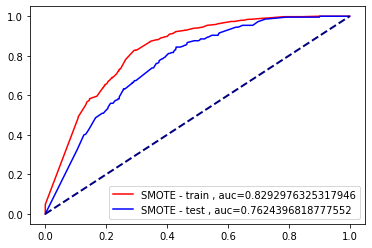

In [60]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

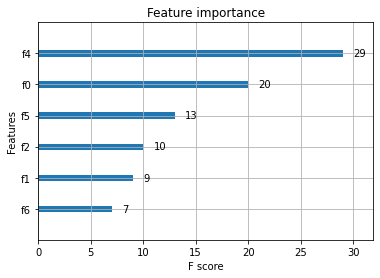

In [62]:
xgb.plot_importance(xgb_model_SMOTE)